In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from fastai.tabular.all import *
import betting.feature_engineering as features

# Analysis of kaggle odds with metadata

In [3]:
data_path = Path('../data/kaggle/with_meta.feather')
raw_df = pd.read_feather(data_path)
raw_df.head()

,match_id,league,match_date,home_team,home_score,away_team,away_score,avg_odds_home_win,avg_odds_draw,avg_odds_away_win,...,home_total_goals_received,home_points,away_rank,away_games_played,away_wins,away_draw,away_lost,away_total_goals_scored,away_total_goals_received,away_points
0,194908,league_one,2005-08-06,RC Lens,2,Marseille,0,2.1783,2.9350,3.2050,...,2,0,18,1,0,0,1,0,2,0
1,194909,league_one,2005-08-06,AC Ajaccio,3,Lille,3,2.6657,2.8643,2.6014,...,0,1,5,1,1,0,0,1,0,3
2,194910,league_one,2005-08-06,Bordeaux,1,AS Nancy,0,1.5957,3.2500,5.7443,...,0,3,15,1,0,0,1,0,1,0
3,194911,league_one,2005-08-06,FC Metz,0,Le Mans,0,1.9500,3.0157,3.8014,...,4,0,14,1,0,0,1,1,2,0
4,194912,league_one,2005-08-06,AS Monaco,0,Auxerre,2,1.6083,3.2117,5.4483,...,0,3,10,1,0,1,0,0,0,1


In [4]:
raw_df.shape, raw_df.columns

((12500, 33),
 Index(['match_id', 'league', 'match_date', 'home_team', 'home_score',
        'away_team', 'away_score', 'avg_odds_home_win', 'avg_odds_draw',
        'avg_odds_away_win', 'max_odds_home_win', 'max_odds_draw',
        'max_odds_away_win', 'season', 'matchday', 'home_goals', 'away_goals',
        'home_rank', 'home_games_played', 'home_wins', 'home_draw', 'home_lost',
        'home_total_goals_scored', 'home_total_goals_received', 'home_points',
        'away_rank', 'away_games_played', 'away_wins', 'away_draw', 'away_lost',
        'away_total_goals_scored', 'away_total_goals_received', 'away_points'],
       dtype='object'))

## Features

### Game results

In [5]:
raw_df['result'] = features.results_from_goals(raw_df, 'home_score', 'away_score')

### Target columns

In [6]:
raw_df = features.add_profit_cols(raw_df, 'max_odds_home_win', 'max_odds_draw', 'max_odds_away_win')
raw_df['y_none'] = 0.
raw_df.head()

,match_id,league,match_date,home_team,home_score,away_team,away_score,avg_odds_home_win,avg_odds_draw,avg_odds_away_win,...,away_draw,away_lost,away_total_goals_scored,away_total_goals_received,away_points,result,y_home,y_draw,y_away,y_none
0,194908,league_one,2005-08-06,RC Lens,2,Marseille,0,2.1783,2.9350,3.2050,...,0,1,0,2,0,-1,1.45,-1.0,-1.0,0.0
1,194909,league_one,2005-08-06,AC Ajaccio,3,Lille,3,2.6657,2.8643,2.6014,...,0,0,1,0,3,0,-1.00,2.0,-1.0,0.0
2,194910,league_one,2005-08-06,Bordeaux,1,AS Nancy,0,1.5957,3.2500,5.7443,...,0,1,0,1,0,-1,0.65,-1.0,-1.0,0.0
3,194911,league_one,2005-08-06,FC Metz,0,Le Mans,0,1.9500,3.0157,3.8014,...,0,1,1,2,0,0,-1.00,2.1,-1.0,0.0
4,194912,league_one,2005-08-06,AS Monaco,0,Auxerre,2,1.6083,3.2117,5.4483,...,1,0,0,0,1,1,-1.00,-1.0,5.0,0.0


### Validation

In [7]:
raw_df.season.unique()

array([2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014])

In [8]:
raw_df['valid'] = False
raw_df.loc[raw_df.season>=2013,'valid'] = True

### Cats and conts

In [9]:
cats = ['league']
conts = ['season', 'matchday',
        'home_rank', 'home_games_played', 'home_wins', 'home_draw', 'home_lost',
        'home_total_goals_scored', 'home_total_goals_received', 'home_points',
        'away_rank', 'away_games_played', 'away_wins', 'away_draw', 'away_lost',
        'away_total_goals_scored', 'away_total_goals_received', 'away_points']

### DataLoaders

In [10]:
to = TabularPandas(raw_df, cat_names=cats, procs=[Categorify, Normalize],
                   cont_names = conts,
                   y_names=['y_home', 'y_draw', 'y_away', 'y_none'],
                   splits=ColSplitter('valid')(raw_df))
dls = to.dataloaders(bs=4096)

In [11]:
dls.show_batch()

,league,season,matchday,home_rank,home_games_played,home_wins,home_draw,home_lost,home_total_goals_scored,home_total_goals_received,home_points,away_rank,away_games_played,away_wins,away_draw,away_lost,away_total_goals_scored,away_total_goals_received,away_points,y_home,y_draw,y_away,y_none
0,premier_league,2009.0,10.0,16.0,9.000000,2.000000e+00,2.000000e+00,5.000000e+00,13.000000,17.000000,8.0,9.0,9.000000,4.000000e+00,2.000000e+00,3.0,12.000000,12.000000,14.000000,1.65,-1.0,-1.0,0.0
1,league_one,2011.0,4.0,16.0,3.000001,-1.271625e-07,2.000000e+00,9.999998e-01,4.000001,6.000000,2.0,17.0,3.000001,-1.232303e-07,2.000000e+00,1.0,1.999999,4.000000,2.000000,0.85,-1.0,-1.0,0.0
2,bundesliga,2009.0,18.0,11.0,17.000000,6.000000e+00,3.000000e+00,8.000000e+00,24.000000,29.000000,21.0,16.0,17.000000,4.000000e+00,4.000000e+00,9.0,18.000000,33.000000,16.000000,-1.00,-1.0,3.8,0.0
3,primera_division,2012.0,14.0,1.0,13.000000,1.200000e+01,9.999998e-01,1.078842e-07,42.999999,15.000000,37.0,14.0,13.000000,4.000000e+00,3.000000e+00,6.0,18.000000,27.000000,15.000000,0.10,-1.0,-1.0,0.0
4,primera_division,2009.0,5.0,2.0,4.000000,4.000000e+00,-1.900826e-07,1.078842e-07,13.000000,2.000000,12.0,10.0,4.000000,2.000000e+00,-1.192610e-07,2.0,3.000001,6.000001,6.000001,0.12,-1.0,-1.0,0.0
5,primera_division,2006.0,23.0,8.0,22.000000,1.000000e+01,3.000000e+00,9.000000e+00,32.000000,30.000000,33.0,19.0,22.000000,2.000000e+00,8.000000e+00,12.0,13.000000,29.000000,14.000000,1.00,-1.0,-1.0,0.0
6,league_one,2011.0,27.0,16.0,26.000000,6.000000e+00,8.000000e+00,1.200000e+01,25.000000,30.000000,26.0,17.0,26.000000,6.000000e+00,8.000000e+00,12.0,24.000000,35.000000,26.000000,-1.00,2.4,-1.0,0.0
7,premier_league,2005.0,7.0,19.0,6.000000,9.999998e-01,-1.900826e-07,5.000000e+00,2.000000,7.999999,3.0,11.0,6.000000,2.000000e+00,1.000000e+00,3.0,4.000000,7.999999,7.000000,-1.00,-1.0,3.5,0.0
8,premier_league,2012.0,15.0,4.0,14.000000,8.000000e+00,2.000000e+00,4.000000e+00,24.000000,18.000000,26.0,9.0,14.000000,4.000000e+00,7.000000e+00,3.0,13.000000,12.000000,19.000000,-1.00,-1.0,2.8,0.0
9,premier_league,2008.0,16.0,3.0,15.000000,9.000000e+00,4.000000e+00,2.000000e+00,29.000000,10.000000,31.0,18.0,15.000000,4.000000e+00,3.000000e+00,8.0,13.000000,24.000000,15.000000,0.60,-1.0,-1.0,0.0


In [12]:
len(dls.train_ds), len(dls.valid_ds)

(9717, 2783)

# Model

In [13]:
def neg_lr_find(learn, offset=5):
    old_loss = learn.loss_func
    def loss(actuals, targets):
        return offset + old_loss(actuals, targets)
    learn.loss_func = loss
    learn.lr_find()
    learn.loss_func = old_loss

In [14]:
config = tabular_config(ps=.1)

learn = tabular_learner(dls, loss_func=features.odds_loss, metrics=features.odds_profit, layers=[5,5,5], wd=1e-1)#, config=config)
learn.model = learn.model.to('cuda')

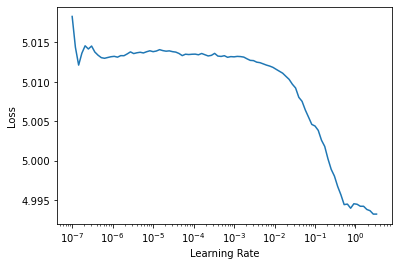

In [15]:
neg_lr_find(learn)

In [16]:
learn.fit_one_cycle(10, 5e-2)

epoch,train_loss,valid_loss,odds_profit,time
0,0.011645,0.005629,-15.666731,00:00
1,0.009229,0.004719,-13.132122,00:00
2,0.007584,0.002531,-7.043163,00:00
3,0.004362,-0.001005,2.795998,00:00
4,0.000568,-0.006019,16.751883,00:00
5,-0.004765,-0.012404,34.518978,00:00
6,-0.007969,-0.015765,43.873901,00:00
7,-0.012111,-0.017558,48.864555,00:00
8,-0.016345,-0.018406,51.222904,00:00
9,-0.020088,-0.019417,54.036720,00:00


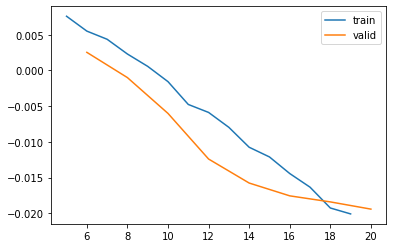

In [17]:
learn.recorder.plot_loss()

## Recent seasons

In [18]:
recent_df = raw_df.loc[raw_df.season>=2008,:].copy()

In [70]:
cats = ['league']
conts = ['matchday',
        'home_rank', 'home_games_played', 'home_wins', 'home_draw', 'home_lost',
        'home_total_goals_scored', 'home_total_goals_received', 'home_points',
        'away_rank', 'away_games_played', 'away_wins', 'away_draw', 'away_lost',
        'away_total_goals_scored', 'away_total_goals_received', 'away_points']

to = TabularPandas(recent_df, cat_names=cats, procs=[Categorify, Normalize],
                   cont_names = conts,
                   y_names=['y_home', 'y_draw', 'y_away', 'y_none'],
                   splits=ColSplitter('valid')(recent_df))
dls = to.dataloaders(bs=4096)

In [139]:
config = tabular_config(ps=.2)

learn = tabular_learner(dls, loss_func=features.odds_loss, metrics=features.odds_profit, layers=[10,5], config=config)
learn.model = learn.model.to('cuda')

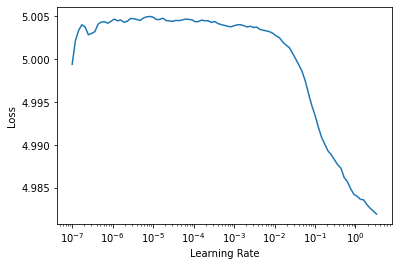

In [140]:
neg_lr_find(learn)

In [141]:
learn.fit_one_cycle(12, 1e-1)

epoch,train_loss,valid_loss,odds_profit,time
0,-0.001153,0.001184,-3.294909,00:00
1,0.001103,0.000789,-2.196216,00:00
2,-0.000095,-0.001480,4.118223,00:00
3,-0.000096,-0.004611,12.831199,00:00
4,-0.004247,-0.013067,36.364162,00:00
5,-0.007151,-0.027073,75.343979,00:00
6,-0.011096,-0.035723,99.418358,00:00
7,-0.014598,-0.041710,116.078011,00:00
8,-0.020238,-0.046187,128.538818,00:00
9,-0.023885,-0.047589,132.441132,00:00


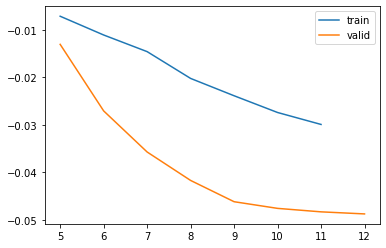

In [142]:
learn.recorder.plot_loss()

In [143]:
learn.export('kaggle_with_meta_4875.model')

# Season evaluation

In [144]:
def predict_df(learner, df, cols, softmax=True):
    test_df = df.loc[:, cols].copy()
    dl = learner.dls.test_dl(test_df)
    preds, _ = learner.get_preds(dl=dl)
    
    if softmax:
        preds = F.softmax(preds, dim=1)
    return preds

def df_profit(learner, df, input_cols, target_cols):
    preds = predict_df(learner, df, input_cols, softmax=False)
    targets = df.loc[:,target_cols].values
    
    return features.odds_profit(preds, targets).item()

In [145]:
learn = load_learner('kaggle_with_meta_4875.model')

In [146]:
target_cols = ['y_home', 'y_draw', 'y_away', 'y_none']

In [147]:
for season, df in recent_df.groupby('season'):
    print(season, df_profit(learn, df, cats+conts, target_cols))

2008 11.595441751600871


2009 96.9498134864035


2010 2.6759565886255587


2011 114.36115740021552


2012 53.09566434661135


2013 56.78454403457578


2014 78.90312145684838


In [148]:
for league, df in recent_df.groupby('league'):
    print(league, df_profit(learn, df, cats+conts, target_cols))

bundesliga 87.41380149108613


league_one 106.55259023748313


premier_league 97.20079147791282


primera_division 123.1985154546201


# History

In [149]:
recent_df.sort_values('match_date', inplace=True)
recent_df.head()

,match_id,league,match_date,home_team,home_score,away_team,away_score,avg_odds_home_win,avg_odds_draw,avg_odds_away_win,...,away_lost,away_total_goals_scored,away_total_goals_received,away_points,result,y_home,y_draw,y_away,y_none,valid
4187,343195,league_one,2008-08-16,Saint-Étienne,2,Sochaux,1,1.7708,3.2200,4.6150,...,1,1,2,0,-1,0.85,-1.00,-1.0,0.0,False
4188,343196,league_one,2008-08-16,Toulouse,2,HAC,1,2.1309,2.9855,3.5700,...,0,1,0,3,-1,1.27,-1.00,-1.0,0.0,False
4189,343197,league_one,2008-08-16,PSG,1,Bordeaux,0,2.4500,2.9691,2.9291,...,0,2,1,3,-1,1.60,-1.00,-1.0,0.0,False
4190,343194,league_one,2008-08-16,OGC Nizza,2,AS Nancy,1,2.3117,2.8958,3.1725,...,0,0,0,1,-1,1.40,-1.00,-1.0,0.0,False
4191,343193,league_one,2008-08-16,FC Nantes,1,AS Monaco,1,2.4492,2.9377,2.9431,...,0,1,0,3,0,-1.00,2.01,-1.0,0.0,False


In [150]:
def accumulate_profits(profits, amount=1.):
    accumulated = [profits[0]]
    for profit in profits[1:]:
        accumulated.append(accumulated[-1]-amount)
        accumulated.append(accumulated[-1]+(amount*(profit+1)))
    return np.array(accumulated)

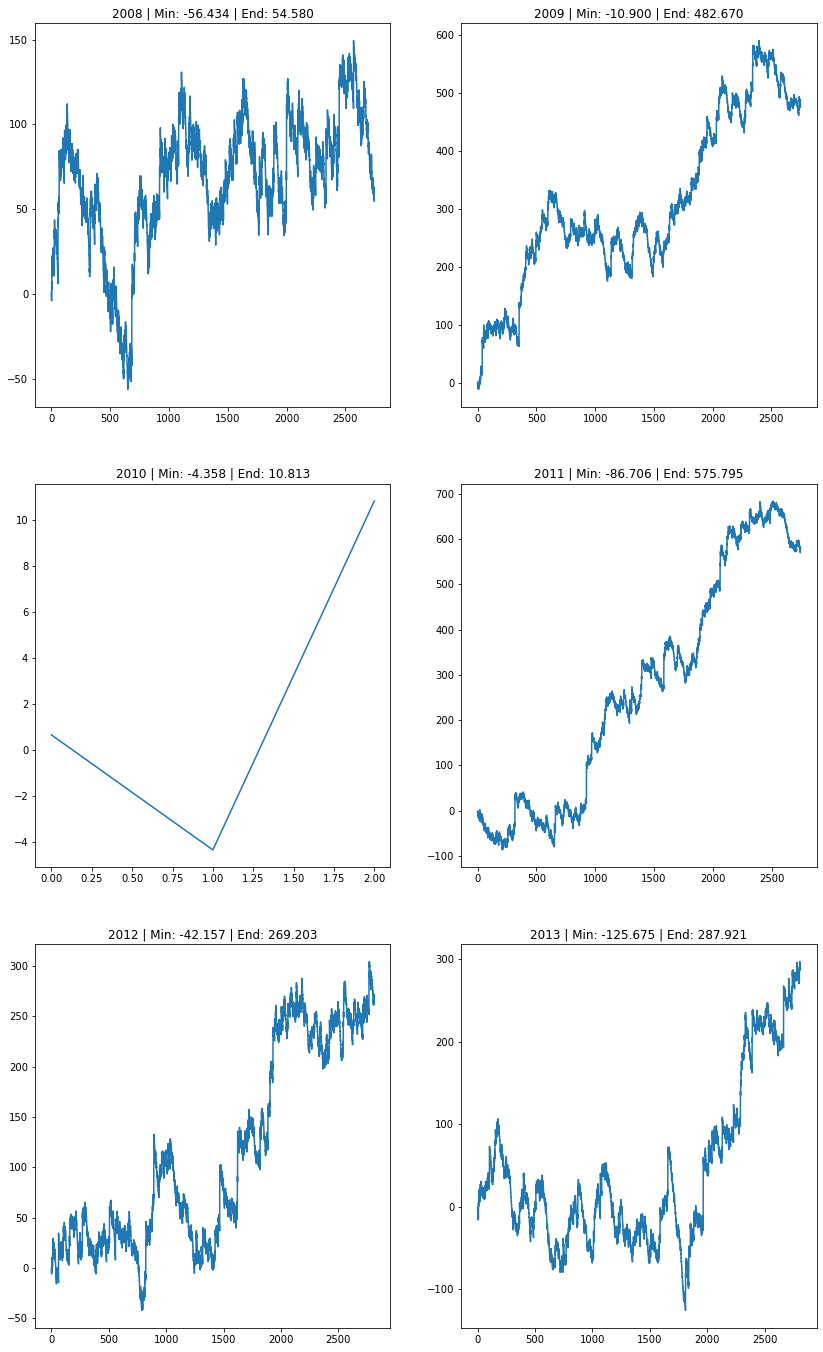

In [152]:
n_plots = len(recent_df.season.unique())

fig, axes = plt.subplots(nrows=n_plots//2, ncols=2, figsize=(14,7*n_plots//2))

for ax, (season, df) in zip(axes.flatten(), recent_df.groupby('season')):
    preds = predict_df(learn, df, cats+conts)
    targets = df.loc[:,target_cols].values
    profits = (preds*targets).sum(dim=1)
    
    accumulated_profits = accumulate_profits(profits, amount=5)

    ax.plot(accumulated_profits)
    ax.set_title(f'{season} | Min: {min(accumulated_profits):.3f} | End: {accumulated_profits[-1]:.3f}')

plt.show()